In [1]:
%pylab inline
from pygadgetreader import *
from astropy import units as u
from astropy import constants
from scipy.special import kv, iv
from profiles import *

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

In [3]:
M_halo = 1.57E12
A_halo = 40.85
M_B1 = 1.14E10
A_B = 0.7
M_B2 = 1.4E10


In [4]:
I_disk = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'pos', 'disk')
I_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'mass', 'disk')
I_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'vel', 'disk')
I_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_000.hdf5', 'pot', 'disk')

B_disk = readsnap('../data/ICs/MW/paul/MWN2vir_010.hdf5', 'pos', 'disk')
B_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_010.hdf5', 'mass', 'disk')
B_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_010.hdf5', 'vel', 'disk')
B_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_010.hdf5', 'pot', 'disk')

C_disk = readsnap('../data/ICs/MW/paul/MWN2vir_020.hdf5', 'pos', 'disk')
C_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_020.hdf5', 'mass', 'disk')
C_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_020.hdf5', 'vel', 'disk')
C_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_020.hdf5', 'pot', 'disk')

D_disk = readsnap('../data/ICs/MW/paul/MWN2vir_035.hdf5', 'pos', 'disk')
D_diskM = readsnap('../data/ICs/MW/paul/MWN2vir_035.hdf5', 'mass', 'disk')
D_diskV = readsnap('../data/ICs/MW/paul/MWN2vir_035.hdf5', 'vel', 'disk')
D_diskP = readsnap('../data/ICs/MW/paul/MWN2vir_035.hdf5', 'pot', 'disk')

#print (F_diskM[0])

Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Potential


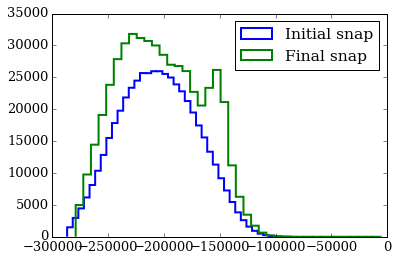

In [6]:
h = hist(I_diskP, bins=40, histtype='step', lw=2, label='Initial snap')
h = hist(D_diskP, bins=40, histtype='step', lw=2, label='Final snap')
legend()

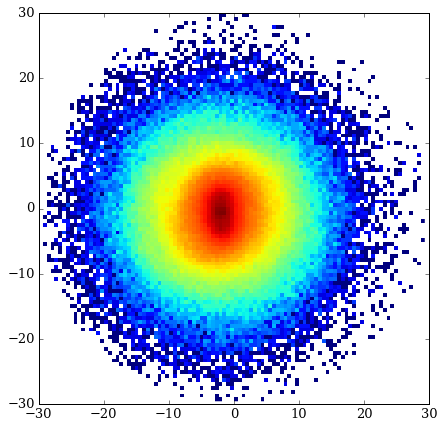

In [12]:
figure(figsize=(7, 7))
#subplot(1, 2, 1)
index_cut = np.where(np.sqrt(C_disk[:,0]**2.0 + C_disk[:,1]**2.0 + C_disk[:,2]**2.0) < 30)[0]
HR = hist2d(C_disk[index_cut,0], C_disk[index_cut,1], bins=100, norm=mpl.colors.LogNorm())
xlim(-20, 20)
ylim(-20, 20)
#colorbar()

axis('equal')

#subplot(1, 2, 2)
#MR = hist2d(F_disk[:,0], F_disk[:,1], bins=100, norm=mpl.colors.LogNorm())
#xlim(-20, 20)
#ylim(-20, 20)
#colorbar()

savefig('evolved_disk.pdf', bbox_inches='tight')


In [13]:
def CM_correction(x, y, z, pot):
    CM = np.where(pot == min(pot))[0]
    xc = x - x[CM]
    yc = y - y[CM]
    zc = z - z[CM]
    print x[CM], y[CM], z[CM]
    return xc, yc, zc

def VCM_correction(x, y, z, vx, vy, vz):
    center = np.where((x**2+y**2+z**2)<4.0)[0]
    N = len(center)
    vxcm = sum(vx[center])/N
    vycm = sum(vy[center])/N
    vzcm = sum(vz[center])/N
    print vxcm, vycm, vzcm
    vxc = vx - vxcm
    vyc = vy - vycm
    vzc = vz - vzcm
    return vxc, vyc, vzc

def rot_curve1(x, y, z, vx, vy, vz):
    R = np.linspace(0.1, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((np.sqrt(x**2.0 + y**2.0) < R[i+1]) & (np.sqrt(x**2.0 + y**2.0) > R[i]) & (z<0.2) & (z>-0.2))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2 + vz[bin_cut]**2.0))
    return R, vc


def rot_curve2(x, y, z, vx, vy, vz):
    R = np.linspace(0, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((x < R[i+1]) & ((x) > R[i]) & (z<0.5) & (z>-0.5))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2))
    return R, vc

def rot_curve3(x, y, z):
    R = np.linspace(0.1, 30, 80)
    G = constants.G
    G = G.to(u.km**3/u.s**2/u.Msun)
    mp = 1.044225e+39 * u.gram / 0.7
    mp = mp.to(u.Msun)
    conv = 1.0 * u.kpc
    conv = conv.to(u.km)
    EM = np.zeros(80)
    for i in range(len(R)):
        ER = np.where(np.sqrt(x**2+y**2)<R[i])
        TM = len(x[ER]) * mp.value
        EM[i] = np.sqrt(G.value * TM / (R[i] * conv.value) )
    return R, EM

In [17]:
I_Xc, I_Yc, I_Zc = CM_correction(I_disk[:,0], I_disk[:,1], I_disk[:,2], I_diskP)
B_Xc, B_Yc, B_Zc = CM_correction(B_disk[:,0], B_disk[:,1], B_disk[:,2], B_diskP)
C_Xc, C_Yc, C_Zc = CM_correction(C_disk[:,0], C_disk[:,1], C_disk[:,2], C_diskP)
D_Xc, D_Yc, D_Zc = CM_correction(D_disk[:,0], D_disk[:,1], D_disk[:,2], D_diskP)

I_Vxc, I_Vyc, I_Vzc = VCM_correction(I_Xc, I_Yc, I_Zc, I_diskV[:,0], I_diskV[:,1], I_diskV[:,2])
B_Vxc, B_Vyc, B_Vzc = VCM_correction(B_Xc, B_Yc, B_Zc, B_diskV[:,0], B_diskV[:,1], B_diskV[:,2])
C_Vxc, C_Vyc, C_Vzc = VCM_correction(C_Xc, C_Yc, C_Zc, C_diskV[:,0], C_diskV[:,1], C_diskV[:,2])
D_Vxc, D_Vyc, D_Vzc = VCM_correction(D_Xc, D_Yc, D_Zc, D_diskV[:,0], D_diskV[:,1], D_diskV[:,2])



[ 0.00254] [ 0.03600619] [ 0.03871866]
[-0.7854591] [-0.41886979] [-0.975878]
[-2.04957962] [-0.62613678] [-2.79367948]
[-5.47682667] [-0.90861756] [-6.66066122]
-1.85156594466 -0.913364899798 -0.00712399499818
1.58285862145 -0.825504496595 -1.98534187156
-6.15271345226 -0.82031579492 -4.42245515003
-3.50274557037 0.357333901268 -5.81500219676


In [24]:
rot_curve_d = loadtxt('../data/ICs/MW/paul/rotcurve2.txt', skiprows=1)
r = rot_curve_d[:,0]
total = rot_curve_d[:,1]
vcd = rot_curve_d[:,3]

In [19]:
def halo_correction(Mhalo, ahalo, Mbulge, cbulge, v_d, R_d):
    vc_h = vc_hernquist(ahalo, 0, R_d, 0, Mhalo)
    vc_b = vc_hernquist(cbulge, 0, R_d, 0, Mbulge)
    return np.sqrt(v_d**2.0)

In [22]:
RI, VI = rot_curve1(I_Xc, I_Yc, I_Zc, I_Vxc, I_Vyc, I_Vzc)
RB, VB = rot_curve1(B_Xc, B_Yc, B_Zc, B_Vxc, B_Vyc, B_Vzc)
RC, VC = rot_curve1(C_Xc, C_Yc, C_Zc, C_Vxc, C_Vyc, C_Vzc)
RD, VD = rot_curve1(D_Xc, D_Yc, D_Zc, D_Vxc, D_Vyc, D_Vzc)

Rd = np.linspace(0.1, 30, 30)
#VDI = halo_correction(M_halo, A_halo, M_B2, A_B, VI, Rd)#
#VDF = halo_correction(M_halo, A_halo, M_B2, A_B, VF, Rd)

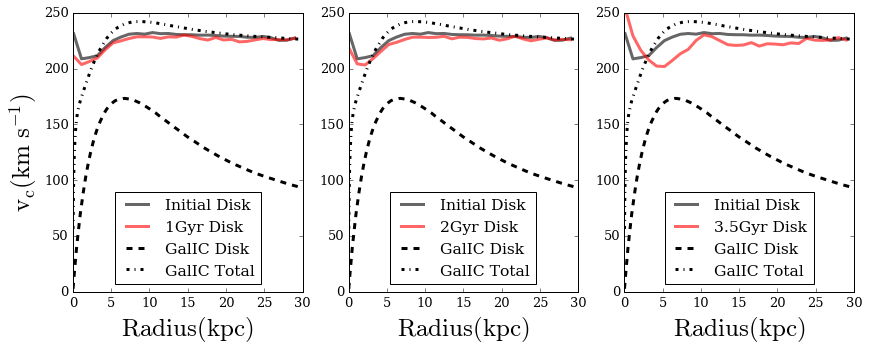

In [30]:
figure(figsize=(14, 5))
subplot(1, 3, 1)
plot(RI[:-1], VI[:-1], c='k', alpha=0.6, label='Initial Disk', lw=3)
plot(RB[:-1], VB[:-1], c='r', alpha=0.6, label='1Gyr Disk', lw=3)
plot(r, vcd, lw=3, c='k', ls='--', label='GalIC Disk')
plot(r, total, lw=3, c='k', ls='-.', label='GalIC Total')


legend(loc='lower center')
xlim(0, 30)
ylim(0, 250)
xlabel('$\mathrm{Radius(kpc)}$', fontsize=25)
ylabel('$\mathrm{v_c(km\ s^{-1}})$', fontsize=25)

subplot(1, 3, 2)
plot(RI[:-1], VI[:-1], c='k', alpha=0.6, label='Initial Disk', lw=3)
plot(RC[:-1], VC[:-1], c='r', alpha=0.6, label='2Gyr Disk', lw=3)
plot(r, vcd, lw=3, c='k', ls='--', label='GalIC Disk')
plot(r, total, lw=3, c='k', ls='-.', label='GalIC Total')
xlim(0, 30)
ylim(0, 250)
xlabel('$\mathrm{Radius(kpc)}$', fontsize=25)
legend(loc='lower center')


subplot(1, 3, 3)
plot(RI[:-1], VI[:-1], c='k', alpha=0.6, label='Initial Disk', lw=3)
plot(RD[:-1], VD[:-1], c='r', alpha=0.6, label='3.5Gyr Disk', lw=3)
plot(r, vcd, lw=3, c='k', ls='--', label='GalIC Disk')
plot(r, total, lw=3, c='k', ls='-.', label='GalIC Total')
xlim(0, 30)
ylim(0, 250)
legend(loc='lower center')

xlabel('$\mathrm{Radius(kpc)}$', fontsize=25)


savefig('Disk_rotcurve.pdf')



In [221]:
def exponential_rc(x, y, r_d, M):
    M = M*u.Msun
    r_d = r_d * u.kpc
    r = np.sqrt(x**2.0 + y**2.0)*u.kpc
    y = r/(2*r_d)
    Sigma = M/(2.0*np.pi*r_d**2)
    G = constants.G
    G = G.to(u.kpc**3/u.s**2/u.Msun)
    # Mod. Bessel functions.
    I0 = iv(0, y.value)
    I1 = iv(1, y.value)
    K0 = kv(0, y.value)
    K1 = kv(1, y.value)
    vc2 = 4.0*np.pi*G*Sigma*r_d*y**2.0*(I0*K0-I1*K1)
    vc = np.sqrt(vc2)    
    vc = vc.to(u.km/u.s)
    return vc

In [219]:
vce = exponential_rc(I_Xc, I_Yc, 3.1, 6.9E10)
#vcf = exponential_rc(F_Xc, F_Yc, 2.5)

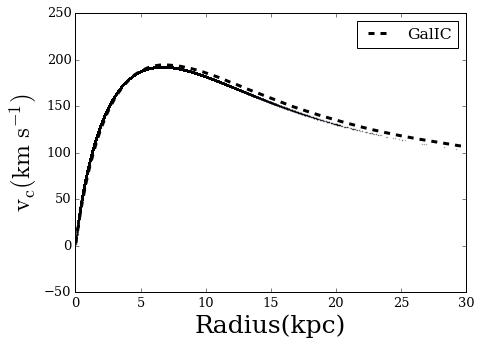

In [220]:
scatter(np.sqrt(I_Xc**2 + I_Yc**2), vce, alpha=0.5, s=0.1)
#scatter(np.sqrt(F_Xc**2 + F_Yc**2), vcf, alpha=0.5, s=0.1)

plot(r, vcd, lw=3, c='k', ls='--', label='GalIC')
xlim(0, 30)
legend()
xlabel('Radius(kpc)', fontsize=25)
ylabel('$\mathrm{v_c(km\ s^{-1}})$', fontsize=25)
savefig('Disk_rc.png')
